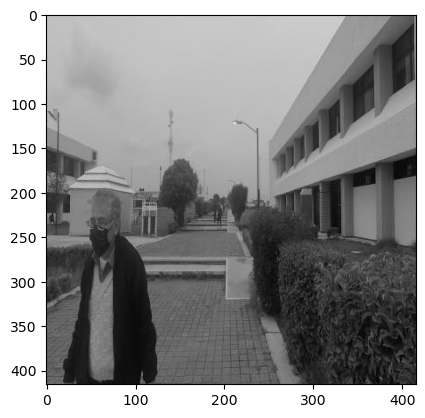

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import algoritmos.harris as hs

img = cv2.imread('../src/images/test/GOPR0141_MP4-195_jpg.rf.5ed66cd884da63e15b570f0db8d88740.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [2]:
##################################### HARRIS DETECTION ALGORITHM #########################################
gaussbox=3
k=0.04
threshold=0.05
window_size=5

algo_hs = hs.harris_detect(gaussbox,k,threshold,window_size)

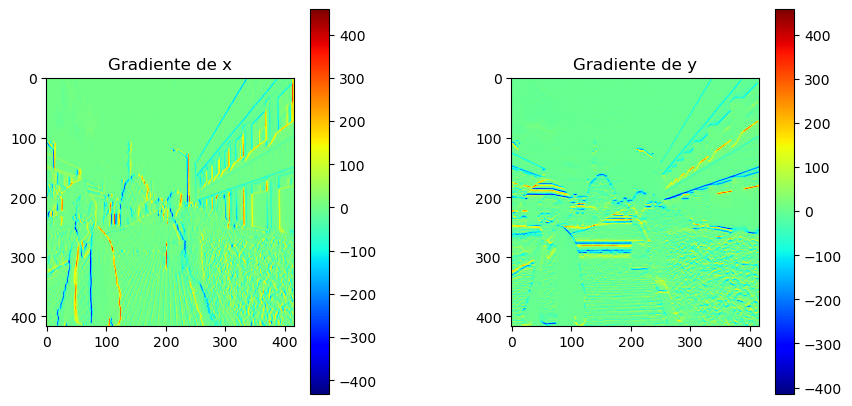

In [3]:
Ix, Iy = algo_hs.calc_grad(img)

plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.imshow(Ix, cmap='jet') 
plt.colorbar()
plt.title("Gradiente de x")

plt.subplot(1,2,2)
plt.imshow(Iy, cmap='jet') 
plt.colorbar()
plt.title("Gradiente de y")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [4]:
Ix2, Iy2, Ixy = algo_hs.calc_grad_prod(Ix,Iy)
Ix2, Iy2, Ixy = algo_hs.gauss_filter(Ix2, Iy2, Ixy)

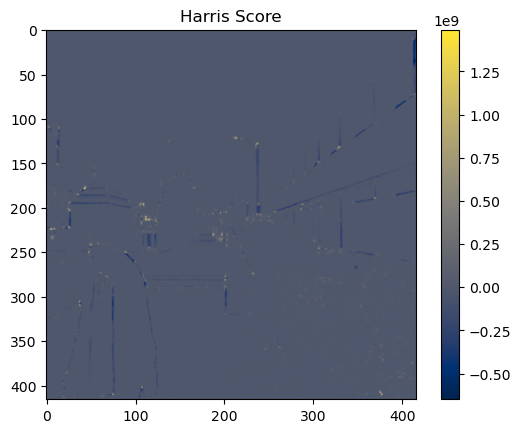

In [5]:
R = algo_hs.calc_harris_score(Ix2, Iy2, Ixy)

plt.imshow(R, cmap='cividis') 
plt.colorbar()
plt.title("Harris Score")
plt.show()

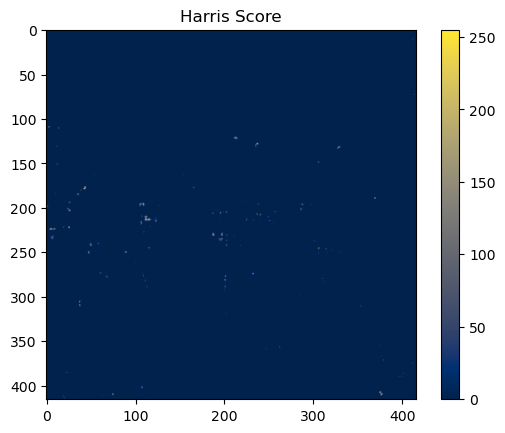

In [6]:
R_norm = algo_hs.normalize_thresh(R)

plt.imshow(R_norm, cmap="cividis") 
plt.colorbar()
plt.title("Harris Score")
plt.show()

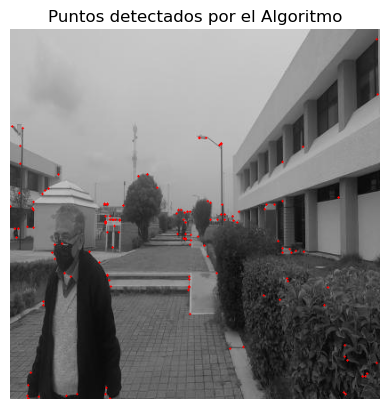

In [7]:
corners = algo_hs.non_max_supre(R_norm)
img2 = algo_hs.draw_corner(corners,img)
algo_hs.draw_img(img2, 'off')
